# Methods used below :
1. Sequence to vector RNN model
2. Sequence to sequence RNN model
3. Simple LSTM model

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import scipy.io

keras = tf.keras

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00580/hungary_chickenpox.zip"
# download and unzip required file
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/chickenpox")

In [3]:
# read the files
train_df = pd.read_csv('/content/chickenpox/hungary_chickenpox.csv')
test_df = pd.read_csv('/content/chickenpox/hungary_county_edges.csv')

In [4]:
train_df['TOTAL'] = train_df.iloc[:,1:].sum(axis=1)
train_df.shape

(522, 22)

In [5]:
train_df.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA,TOTAL
0,03/01/2005,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68,1807
1,10/01/2005,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26,1407
2,17/01/2005,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44,1284
3,24/01/2005,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31,1255
4,31/01/2005,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60,1478


##Visual


In [6]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=5)
    plt.grid(True)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

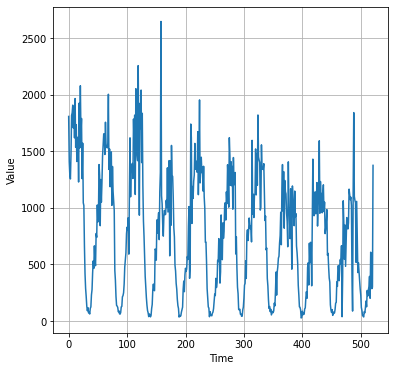

In [8]:
# discarded the date object with integers
# done to find where to split data 
time = np.arange(0,522) 
series = train_df['TOTAL']
plt.figure(figsize=(6,6))
plot_series(time,series)
plt.show()

In [10]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

arr = train_df['TOTAL']
snr = signaltonoise(arr)
snr

array(1.42874787)

In [12]:
# splitting series into training and validation split since data is less 
time_split = 400
time_train = time[:time_split]
x_train = series[:time_split]
time_val = time[time_split:]
x_val = series[time_split:]

# Stateless RNN Models


## Sequence to vector model

In [13]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) #
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size, batch_size=50)

In [ ]:
model = keras.models.Sequential([
      keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[None]),
      keras.layers.SimpleRNN(100,return_sequences=True),
      keras.layers.SimpleRNN(100),
      keras.layers.Dense(1),
      keras.layers.Lambda(lambda x: x * 200.0)
      
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=250, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  


(1e-09, 5.188000255003425, 0.0, 1000.0)

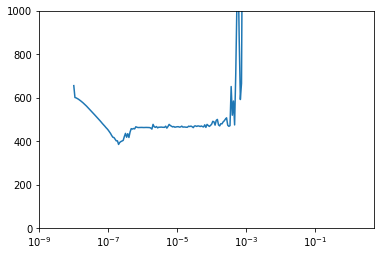

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9,0, 0,1000])

According to this , **2e-8** is more promising *learning rate* in *RNN* for sequence to vector model . This is because the graph is smoothly decreasing here.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size,50)
valid_set = window_dataset(x_val,window_size,50)

# this is a seq2vect model
model = keras.models.Sequential([
          keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[None]),
          keras.layers.SimpleRNN(100,return_sequences=True),
          keras.layers.SimpleRNN(100),
          keras.layers.Dense(1),
          keras.layers.Lambda( lambda x: x*200.0)
])

optimizer = keras.optimizers.SGD(learning_rate=2e-8,momentum=0.98)

model.compile(optimizer,loss=keras.losses.Huber(),metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
      "my_checkpoint", save_best_only=True)

history = model.fit(train_set,validation_data=valid_set,epochs=100,callbacks=[early_stopping, model_checkpoint])


model_checkpoint saves the model in between it finds best.

In [22]:
 model = keras.models.load_model("my_checkpoint")

In [23]:
rnn_forecast = model_forecast(
    model,
    series[time_split - window_size:-1],
    window_size)[:, 0]

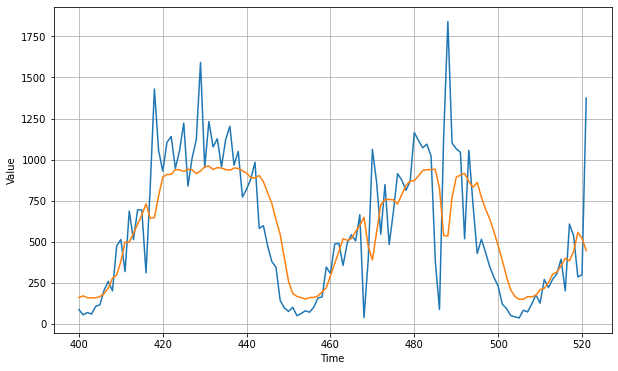

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_val, rnn_forecast).numpy()

190.6468

##sequence to seqence model

In [26]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=110)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1), # applies dense layer at every single time step 
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

(1e-08, 100.0, 300.0, 900.0)

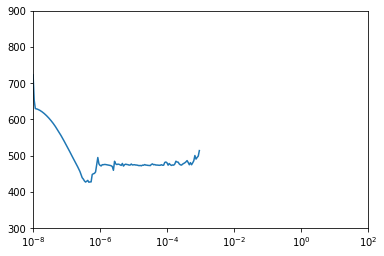

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e+2, 300,900])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=110)
valid_set = seq2seq_window_dataset(x_val, window_size,
                                   batch_size=110)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)

])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping])

In [46]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[time_split - window_size:-1, -1, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


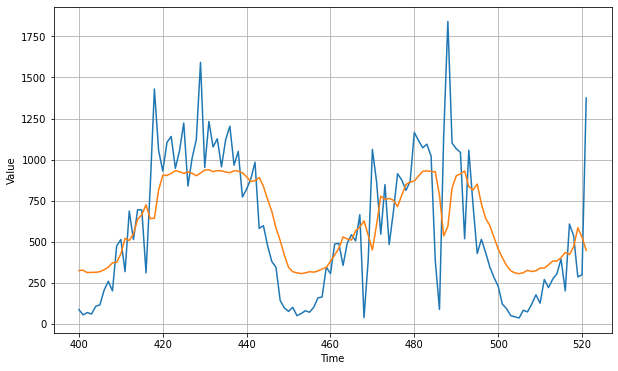

In [47]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [48]:
keras.metrics.mean_absolute_error(x_val,rnn_forecast).numpy()

218.04935

This is better than our moving average model but not close to the best model generated with simple ML implementations.

# Stateful RNN models


In [49]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    # shift is equal to window size , not 1 
    # shuffle also not called since sequential order is important
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [50]:
# to reset state of model at beginning of every epoch
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train,window_size)

model = keras.models.Sequential([
          keras.layers.SimpleRNN(100, return_sequences=True,stateful=True,
                                 batch_input_shape = [1,None,1]),
          keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
          keras.layers.Dense(1),
          keras.layers.Lambda(lambda x: x * 200.0)

])


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=300,
                    callbacks=[lr_schedule, reset_states])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  


(1e-08, 2917.4269635086866, 0.0, 1000.0)

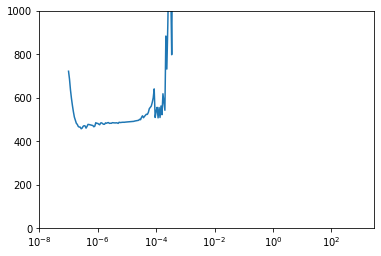

In [72]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 0, 0, 1000])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
val_set = sequential_window_dataset(x_val, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=60)
model.fit(train_set, epochs=500,
          validation_data=val_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

In [91]:
model = keras.models.load_model("my_checkpoint.h5")
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, time_split - 1:-1, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


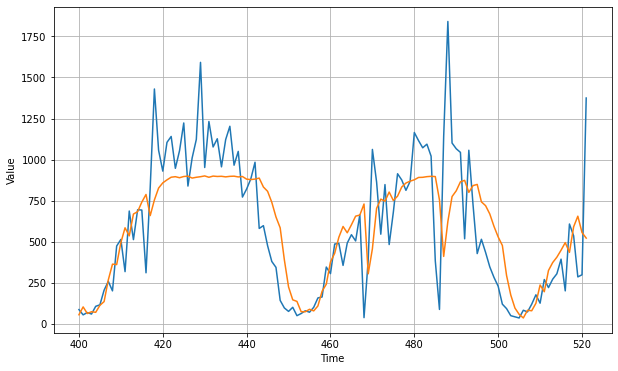

In [92]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [93]:
keras.metrics.mean_absolute_error(x_val,rnn_forecast).numpy()

194.25

# Forecasting with LSTM

In [94]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set  = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1,None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150,
                    callbacks=[lr_schedule, reset_states])

(1e-09, 100.0, 0.0, 1000.0)

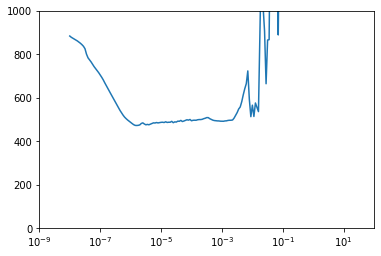

In [96]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e+2, 0, 1000])

As compared to ther curves of scheduler , it has more ups and downs rather than a flat line after convergance.

It also tells that **lr of 1e-7** will be better

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set= sequential_window_dataset(x_val, window_size)


model = keras.models.Sequential([
  keras.layers.LSTM(200, return_sequences=True, stateful=True,
                    batch_input_shape=[1,None, 1]),
  keras.layers.LSTM(200, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

reset_states = ResetStatesCallback()
early_stopping = keras.callbacks.EarlyStopping(patience=70)

optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=300,
                    validation_data=valid_set,
                    callbacks=[early_stopping, reset_states])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


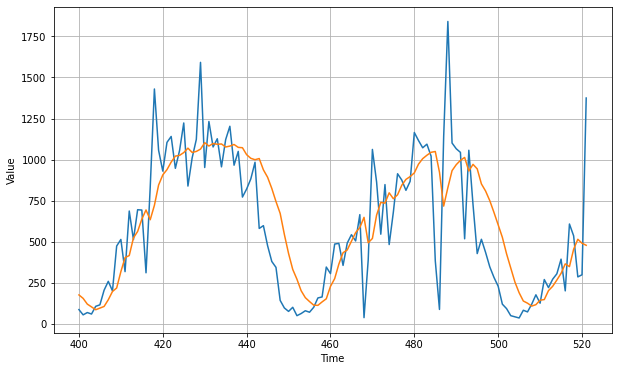

In [115]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, time_split - 1:-1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [116]:
keras.metrics.mean_absolute_error(x_val, rnn_forecast).numpy()

199.0237

LSTM has a low score as compared to other RNN models , which can be due to short size of the dataset. Due to short size of data , RNN and LSTM have not been able to compete with simple RNN models of regression.